<a href="https://colab.research.google.com/github/scardenol/proc_est2/blob/main/oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Se corre una vez al abrir una nueva sesión
# !pip install investpy

In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # gráficas
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pylab as plt
from scipy.optimize import curve_fit # LS fit
from IPython.display import display, Math
from astropy.convolution import convolve, Box1DKernel # Convolución media móvil (LoPass-filter)
import investpy as ip
from sklearn.model_selection import train_test_split

import seaborn as sns # gráficas
plt.style.use('seaborn-darkgrid') # estilo de gráficas
# plt.style.available 

import warnings
warnings.filterwarnings("ignore")

In [45]:
# Carga de datos
# https://investpy.readthedocs.io/_api/commodities.html

commodity = 'Crude Oil WTI'
data = ip.commodities.get_commodity_historical_data(commodity=commodity, from_date='01/07/2020', to_date='01/05/2022')
data = data['Close']

split = int(0.7*len(data))
train = data[:split]
test = data[split-1:]

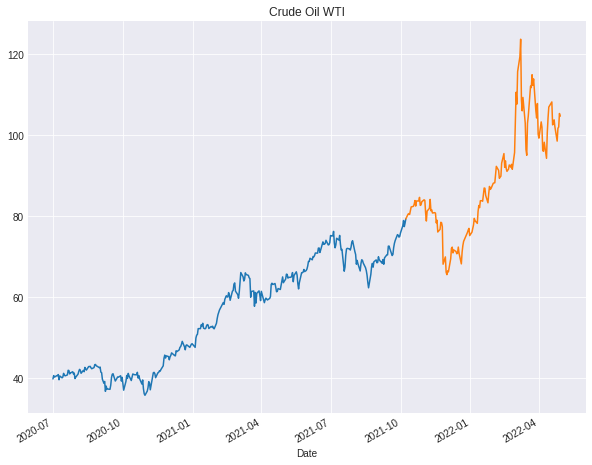

In [46]:
# Visualizar

plt.figure(figsize=(10,8))
# data.plot(title=commodity);
train.plot(title=commodity);
test.plot();

In [15]:
# mu(t) estimada con media móvil
data = train

window = 2 # 31 por la estacionalidad dependiendo del mes del año, asumiendo 30 días + centro
mi = convolve(data,kernel=Box1DKernel(window)) # Equivalente a un filtro pasa bajas
mi = pd.Series(mi, index=data.index)

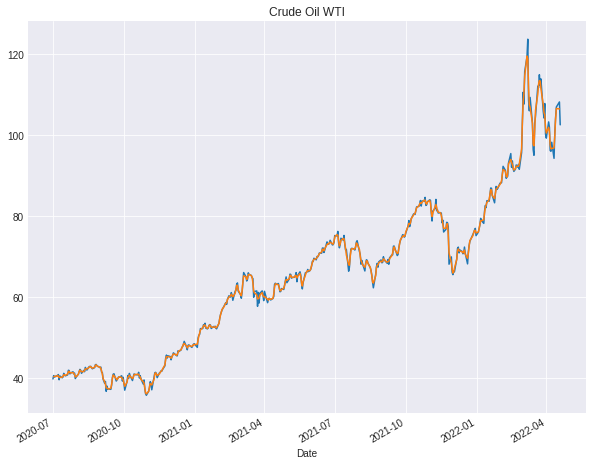

In [16]:
# Visualizar

plt.figure(figsize=(10,8))
train.plot(title=commodity);
mi[1:-1].plot(title=commodity);

In [17]:
# Banoy-Cardeño-Ornstein-Uhlenbeck

p = len(data)
T = p
dt = 1/p

A = (data*data.iloc[1:]).sum()
B = data.iloc[1:].sum()
C = data.sum()
D = T
E = (data.iloc[1:]**2).sum()

alpha_hat = (E*D-B**2-A*D+B*C)/((E*D-B**2)*dt)
mu_hat = (A-E*(1-alpha_hat*dt))/(alpha_hat*B*dt)
sigma_sum = ((data-data.iloc[1:]-alpha_hat*(mu_hat-data.iloc[1:])*dt)**2).sum()
sigma_hat = np.sqrt(1/(T*dt)*sigma_sum)

display(Math(r'\hat{\alpha} = ' + str(round(alpha_hat, 2))))
display(Math(r'\hat{\mu} = ' + str(round(mu_hat, 2))))
display(Math(r'\hat{\sigma} = ' + str(round(sigma_hat, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
l = 1000 # número de simulaciones
data = test

p = len(data) # número de observaciones

X_hat1 = np.zeros((l,p))
X_hat1 = pd.DataFrame(X_hat1)

dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]

alpha = alpha_hat
mu = mu_hat
sigma = sigma_hat

X0 = mu - 0.01 # Valor inicial

for sim in range(l): # Ciclo de simulaciones
  X_hat1.iloc[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución numérica
    X_hat1.iloc[sim, t] = mu + (X_hat1.iloc[sim, t-1] - mu)*np.exp(-alpha*dt) + sigma*np.exp(-alpha*dt)*dBt

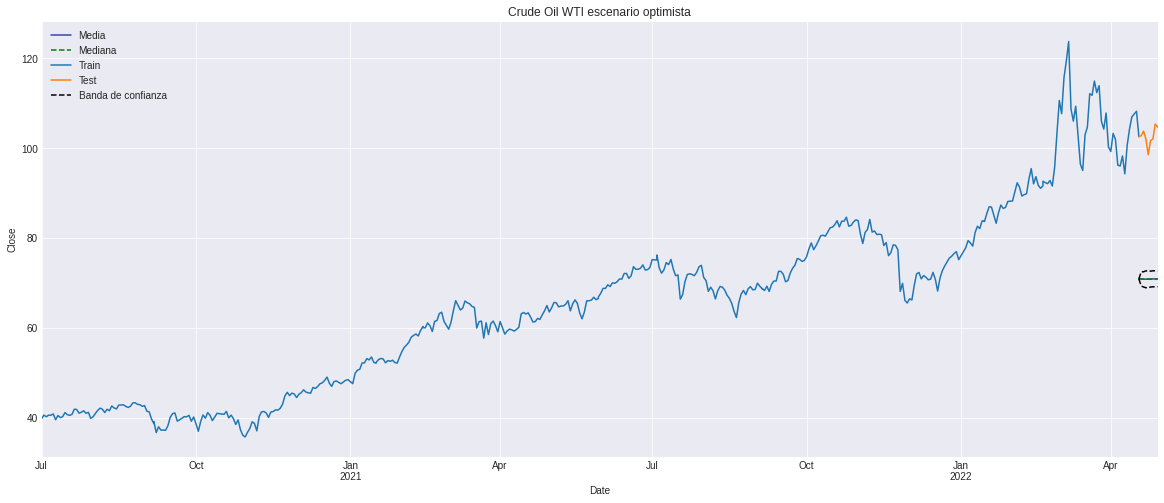

In [21]:
# Visualizar

fig1 = plt.figure(figsize=(20,8))

X_hat_mean1 = pd.Series(X_hat1.mean(axis=0).values, index=data.index)
X_hat_mean1.plot(color='#3743ad');
X_hat_median1 = pd.Series(X_hat1.quantile(q=0.5, axis=0).values, index=data.index)
X_hat_median1.plot(style='--', color='green');

train.plot(title= commodity + ' escenario optimista');
test.plot()

# Bandas de confianza
X_hat_hi1 = pd.Series(X_hat1.quantile(q=0.95, axis=0).values, index=data.index)
X_hat_hi1.plot(style='--', color='black');
X_hat_lo1 = pd.Series(X_hat1.quantile(q=0.05, axis=0).values, index=data.index)
X_hat_lo1.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);